# Diffusion maps with Self-Tuning

## Abstract

I have a basic understanding of the diffusion map [1] after converting [Ann Lee's Matlab code](https://reurl.cc/E3Ykv) into Python (see my privious project). Next, I focus on studying a better version of constructing a diffusion map [3]. In the following article, I will show how this better algorithm build up the diffusion map step by step, then demonstrate it with Python code. After that, I will consolidate what I learn and make a more complete version of discribing diffusion maps, including demonstrate my own code, in the next project.

## Introduction to Local Scaling

The scaling parameter $\sigma$ is some measure of when two points are considered similar, it is often picked manually. [3] suggested that instead of selecting a single scaling parameter $\sigma$, we should calculate local scaling parameter $\sigma_i$ for each data point $x_i$, it allows self-tuning of the point-to-point distances.

The selection of $\sigma_i$ can be done by studying the local statistics of the neighborhood of point $x_i$.A simple choice is $ \sigma_i=d(x_i,x_s) $, where $x_s$ is the $s$'th neighbor of point $x_i$, and by [3]'s experiments, $s=7$ can gave good results for all datas.

## Framework

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^p$, we construct the diffusion map by using following steps (A better version of Ng-Jordan-Weiss(NJW) algorithm provided in [3]):

### 1. Define a kernel and create the kernel matrix

Consider Guassian kernel $$ k(x_{i},x_{j}) = \exp(-\frac{\lVert x_{i}-x_{j} \rVert^2}{\sigma_i \sigma_j}) $$
where $ \sigma_i=\lVert x_i-x_s \rVert^2 $ and $x_s$ is the $s$'th neighbor of point $x_i$. Define the kernel matrix $K$, with entries $ K_{ij}=k(x_{i},x_{j}) $.

### 2. Find the normalize affinity matrix $Q$

Define $D$ to be a $n*n$ diagonal matrix with $$ D_{ii}=(\sum_{j=1}^n K_{ij})^{1/2}, $$
and construct the normalize affinity matrix $$ Q=D^{-1}KD^{-1}. $$

### 3. Find eigenvectors of $Q$ and form the matrix $Z$

Simply compute the first $c$ largest eigenvalues of $Q$ and get the corresponding eigenvectors, $e_1,...,e_c$, then define the matrix $$Z=
\left[
\begin{matrix} e_1 &e_2 &\cdots &e_c \end{matrix}
\right]
\in \mathbb{R}^{n \times c}
$$

### 4. Define a diffusion map and treat each row as a point coordinate

Let $Y$ be a diffusion map, which map corrdinates between data and diffusion space [2], with its column
$$ Y_{ij}=\frac{Z_{ij}}{\sqrt{\sum_{j=1}^{c} Z_{ij}^2}} $$  
It is the row-normalize matrix of $Z$.

### 5. Cluster via k-means

Using k-means function to get the labeling of the datas, here k is a manually select number of groups.

## Implementation

Python code that implement diffusion maps using the steps above.

### 1. Import some libraries for programming

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 2. Define functions

The functioning of get_K is to get the Guassian kernel matrix.

In [2]:
def get_K(D, sigma):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-D[i][j]*D[i][j]/(sigma[i]*sigma[j])) )
    K = array(list1).reshape(n, n)
    
    return K    #Guassian kernel matrix

The functioning of get_Q is to get the matrix $Q$ we mention above.

In [3]:
def get_Q(K):
    list1=[]
    
    for i in range(n): list1.append( sqrt(sum(K[i])) )
    D = diag(list1)
    Q = dot( dot(inv(D), K), inv(D) )
    
    return Q    #Q is the matrix we define earlier, i.e., Q=D^(-1)KD^(-1)

The functioning of get_eig is to get the eigenvectors of $Q$. 

In [4]:
from scipy.sparse.linalg import svds

def get_eig(Q, c):
    [Z, S, V] = svds(Q, c)  #compute the largest c singular values/vectors for a sparse matrix
                            #since Q is a real symmetric matrix, singular values and non-negative
                            #eigenvalues coincide

    for i in range(n): Z[i]=flip(Z[i])
    
    return Z    #matrix of eigenvectors of Q

The functioning of get_Y is to construct the diffusion map.

In [7]:
def get_Y(Z, c):
    list1=[]
    
    for i in range(n):
        tempsum=0
        for j in range(c): tempsum = tempsum + Z[i][j]*Z[i][j]
        for j in range(c): list1.append(sqrt(tempsum))
    tonormalize = array(list1).reshape(n,c)
    
    Y = Z/tonormalize    #entries division
       
    return Y    #diffusion map

The functioning of get_labels is to get the labels of data via k-means.

In [8]:
from sklearn.cluster import KMeans

def get_labels(Y):

    kmeans = KMeans(clusters)
    kmeans = kmeans.fit(Y)
    labels = array(kmeans.predict(Y)).reshape(n,1)

    return labels

### 3. Load data

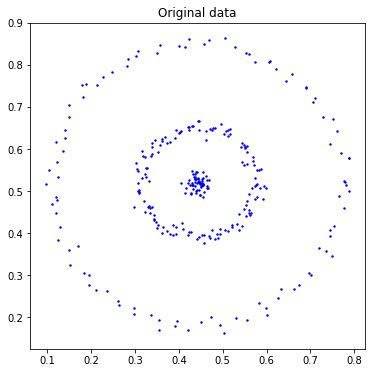

In [9]:
from scipy.io import loadmat

ori = loadmat('Data/Data2.mat')

n = len(ori['data'])       #number of points
p = len(ori['data'][0])    #dimension of points

for i in range(n): plt.scatter(ori['data'][i][0],ori['data'][i][1], s=2, c="blue")
plt.title("Original data")
plt.gcf().set_size_inches(6,6)
plt.show()

### 4. Set parameters for diffusion map

D : matrix of Euclidean distance of data points in $\mathbb{R}^p$.  
c : the largest $c$ eigenvalues, that is, the largest dimension we consider.  
s : parameter $s$ in the Guassian kernel function.  
sigma : a list of local scaling parameters $\sigma_i$, which is required in the Guassian kernel function.  
clusters : numbers of groups.

In [10]:
from scipy.spatial.distance import squareform, pdist
D = squareform(pdist(ori['data']))
c = 10

s = 7
sigma=[]
D_sort = sort(D,1)    # distance of one point to another arrange in descending power
for i in range(n): sigma.append( D_sort[i][s+1] )
    
clusters = 3

### 5. Calculation

In [11]:
def diffuse(D, sigma, c):
    
    K = get_K(D, sigma)
    Q = get_Q(K)
    Z = get_eig(Q, c)
    Y = get_Y(Z, c)
    labels = get_labels(Y)
    
    return Y, labels

In [12]:
Y, labels = diffuse(D, sigma, c)

### 6. Display the result

##### 6.1. Show the diffusion space

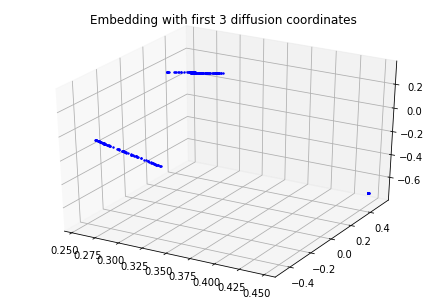

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
for i in range(n): ax.scatter(Y[i][0],Y[i][1],Y[i][2],s=2, c='b')
ax.set_title('Embedding with first 3 diffusion coordinates')
plt.show()

##### 6.2. Show the labeling

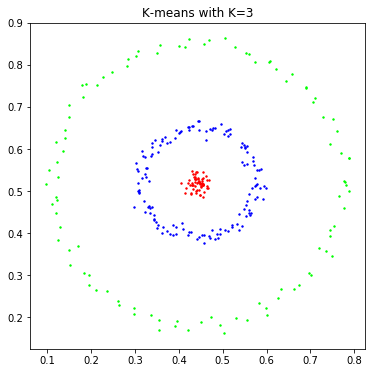

In [14]:
cmap = cm.brg
norm = Normalize(1, clusters)

for i in range(n):
    plt.scatter(ori['data'][i][0], ori['data'][i][1], s=2, c=cmap(norm(labels[i]+1)) )
plt.title('K-means with K=3')
plt.gcf().set_size_inches(6,6)
plt.show()

## Conclusion

Algorithm which [3] provided does not follow the original discription of diffusion map, a simple example is that its map does not related to eigenvalues of diffusion matrix, but it still came up with good results just like [Ann Lee's code]() did. It seems that there is no unique solution for constructing a diffusion map, one could adjust the algorithm due to the data they need to analyze. In the [next project](), I will then give a complete discription for diffusion map and display my algorithm.

## References

[1] R.R. Coifman and S. Lafon, Diffusion maps, Applied and computational harmonic analysis, 21(1):5–30, 2006  
[2] J. de la Porte, B. M. Herbst, W. Hereman and S. J. van der Walt., An Introduction to Diffusion Maps, Proceedings of the Nineteenth Annual Symposium of the Pattern Recognition Association of South Africa, 2008  
[3] L. Zelnik-Manor and P. Perona, Self-Tuning Spectral Clustering, Advances in Neural Information Processing Systems 17, pp. 1601-1608, 2005, (NIPS’2004)